<a href="https://colab.research.google.com/github/HassanChowdhry/DeepReinforcementLearning/blob/main/Frozenlake_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install swig
%pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379418 sha256=5236fa6ce575cfefcadd45758eb42c408b6b2b883ff54b212f4082f30f674f41
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [3]:
import gymnasium as gym
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

sns.set_theme()

## Parameters we’ll use

In [4]:
class Params(NamedTuple):
  total_episodes: int  # Total episodes
  learning_rate: float  # Learning rate
  gamma: float  # Discounting rate
  epsilon: float  # Exploration probability
  map_size: int  # Number of tiles of one side of the squared environment
  seed: int  # Define a seed so that we get reproducible results
  is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
  n_runs: int  # Number of runs
  action_size: int | None  # Number of possible actions
  state_size: int | None  # Number of possible states
  proba_frozen: float  # Probability that a tile is frozen
  savefig_folder: Path  # Root folder where plots are saved

params = Params(
  total_episodes=2000,
  learning_rate=0.8,
  gamma=0.99,
  epsilon=0.1,
  map_size=5,
  seed=123,
  is_slippery=False,
  n_runs=20,
  action_size=None,
  state_size=None,
  proba_frozen=0.9,
  savefig_folder=Path("../../_static/img/tutorials/"),
)

rng = np.random.default_rng(params.seed)
params.savefig_folder.mkdir(parents=True, exist_ok=True)


## The FrozenLake environment

In [5]:
env = gym.make(
  "FrozenLake-v1",
  is_slippery=params.is_slippery,
  render_mode="rgb_array",
  desc=generate_random_map(
      size=params.map_size, p=params.proba_frozen, seed=params.seed
  ),
)

In [8]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

Action size: 4
State size: 25


## Creating the Q-table
In this tutorial we’ll be using Q-learning as our learning algorithm and -greedy to decide which action to pick at each step. You can have a look at the References section for some refreshers on the theory. Now, let’s create our Q-table initialized at zero with the states number as rows and the actions number as columns.

In [19]:
class Qlearning:
  def __init__(self, learning_rate, gamma, action_size, state_size) -> None:
    self.lr = learning_rate
    self.gamma = gamma
    self.action_size = action_size
    self.state_size = state_size
    self.reset_qtable()

  def reset_qtable(self):
    self.qtable = np.zeros((self.state_size, self.action_size))
  def update(self, state, action, reward, new_state):
    """ Update: Q(s, a):= Q(s, a) * lr[R(s, a) + gamma * maxQ(s',a') - Q(s, a)] """
    delta = reward + self.gamma * np.max(self.qtable[new_state, :]) - self.qtable[state, action]
    update = self.qtable[state, action] + self.lr * delta
    return update

class EpsilonGreedy:
  def __init__(self, epsilon):
    self.epsilon = epsilon

  def get_action(self, action_space, state, qtable):
    """Choose an action `a` in the current world state (s)."""
    explor_exploit_tradeoff = rng.uniform(0, 1)

    # xplore
    if explor_exploit_tradeoff < self.epsilon:
      action = action_space.sample()
    # exploit
    else:
      max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
      action = rng.choice(max_ids)
    return action

## Running the environment
Let’s instantiate the learner and the explorer.

In [20]:
learner = Qlearning(
  learning_rate=params.learning_rate,
  gamma = params.gamma,
  action_size = params.action_size,
  state_size = params.state_size
)

explorer = EpsilonGreedy(epsilon=params.epsilon)

This will be our main function to run our environment until the maximum number of episodes params.total_episodes. To account for stochasticity, we will also run our environment a few times

In [21]:
def run_env():
  rewards = np.zeros((params.total_episodes, params.n_runs))
  steps = np.zeros((params.total_episodes, params.n_runs))
  episodes = np.arange(params.total_episodes)
  qtables = np.zeros((params.n_runs, params.state_size, params.action_size)) # run_size, action_size, state_size

  all_states = []
  all_actions = []


  for run in range(params.n_runs):
    learner.reset_qtable()

    for ep in tqdm(
      episodes, desc=f"Run {run + 1}/{params.n_runs}", leave=False
    ):

      state = env.reset(seed=params.seed)[0]
      step = 0
      done = False
      total_rewards = 0

      while not done:
        action = explorer.get_action(
          env.action_space,
          state,
          learner.qtable
        )

        all_states.append(state)
        all_actions.append(action)

        new_state, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        learner.qtable[state, action] = learner.update(
          new_state=new_state,
          reward=reward,
          state=state,
          action=action
        )

        total_rewards += reward
        step += 1
        state = new_state

      rewards[ep, run] = total_rewards
      steps[ep, run] = step
    qtables[run, :, :] = learner.qtable
  return rewards, steps, episodes, qtables, all_states, all_actions

## Visualization
To make it easy to plot the results with Seaborn, we’ll save the main results of the simulation in Pandas dataframes.

In [14]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

We want to plot the policy the agent has learned in the end. To do that we will: 1. extract the best Q-values from the Q-table for each state, 2. get the corresponding best action for those Q-values, 3. map each action to an arrow so we can visualize it.

In [25]:
def qtable_directions_map(qtable, map_size):
  """ Best learned action & map it to arrows """
  qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
  qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)

  directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
  qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
  epsilon = np.finfo(float).eps # min float num

  for idx, val in enumerate(qtable_best_action.flatten()):
    if qtable_val_max.flatten()[idx] > epsilon:
      qtable_directions[idx] = directions[val]

  qtable_directions = qtable_directions.reshape(map_size, map_size)
  return qtable_val_max, qtable_directions


With the following function, we’ll plot on the left the last frame of the simulation. If the agent learned a good policy to solve the task, we expect to see it on the tile of the treasure in the last frame of the video. On the right we’ll plot the policy the agent has learned. Each arrow will represent the best action to choose for each tile/state.

In [16]:
def plot_q_values_map(qtable, env, map_size):
  """Plot the last frame of the simulation and the policy learned."""
  qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

  # Plot the last frame
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  ax[0].imshow(env.render())
  ax[0].axis("off")
  ax[0].set_title("Last frame")

  # Plot the policy
  sns.heatmap(
      qtable_val_max,
      annot=qtable_directions,
      fmt="",
      ax=ax[1],
      cmap=sns.color_palette("Blues", as_cmap=True),
      linewidths=0.7,
      linecolor="black",
      xticklabels=[],
      yticklabels=[],
      annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Q-values\nArrows represent best action")
  for _, spine in ax[1].spines.items():
      spine.set_visible(True)
      spine.set_linewidth(0.7)
      spine.set_color("black")
  img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
  fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
  plt.show()

def plot_states_actions_distribution(states, actions, map_size):
  """Plot the distributions of states and actions."""
  labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  sns.histplot(data=states, ax=ax[0], kde=True)
  ax[0].set_title("States")
  sns.histplot(data=actions, ax=ax[1])
  ax[1].set_xticks(list(labels.values()), labels=labels.keys())
  ax[1].set_title("Actions")
  fig.tight_layout()
  img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
  fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
  plt.show()

Now we’ll be running our agent on a few increasing maps sizes

Map size: 4x4


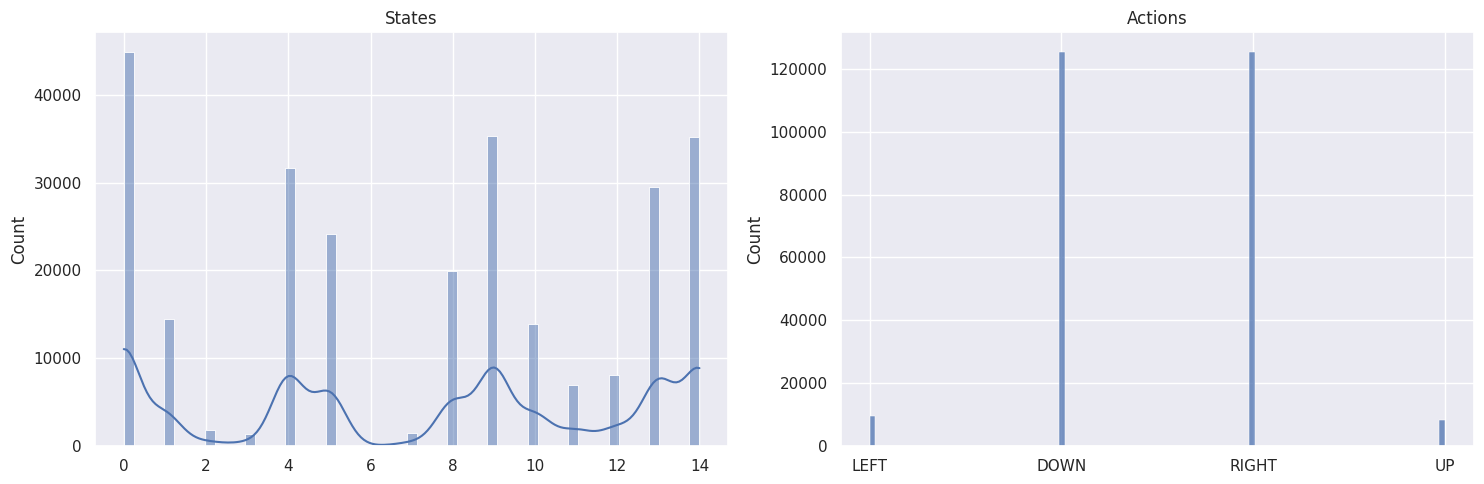

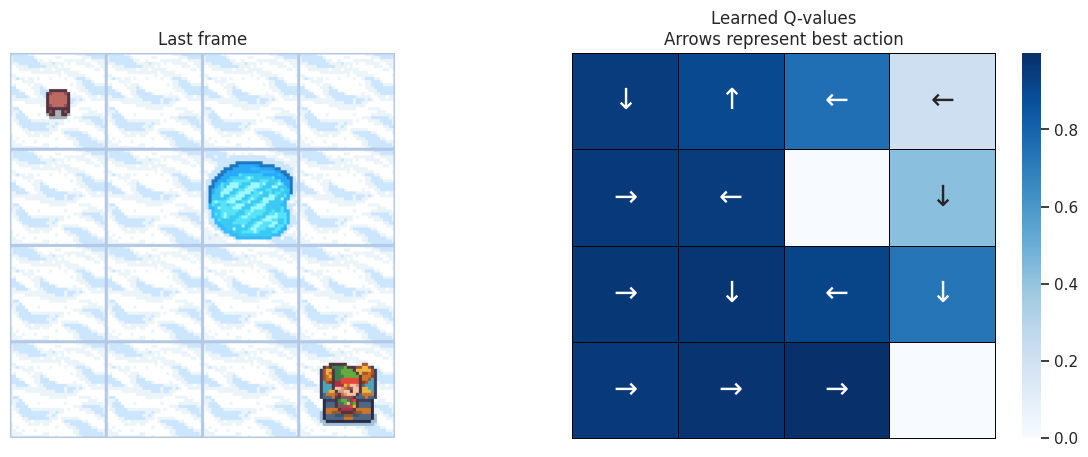

Map size: 7x7


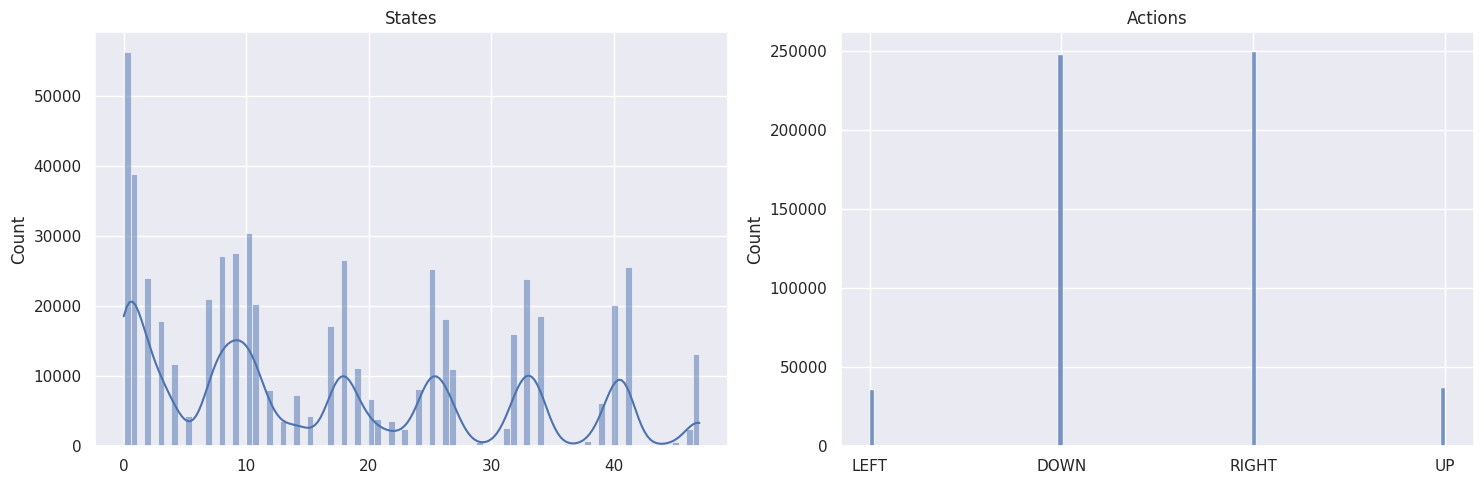

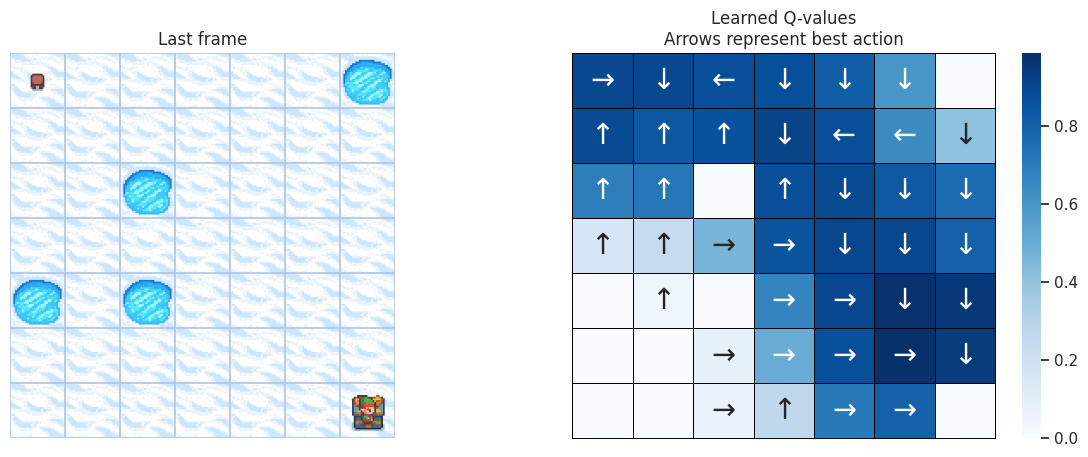

Map size: 9x9


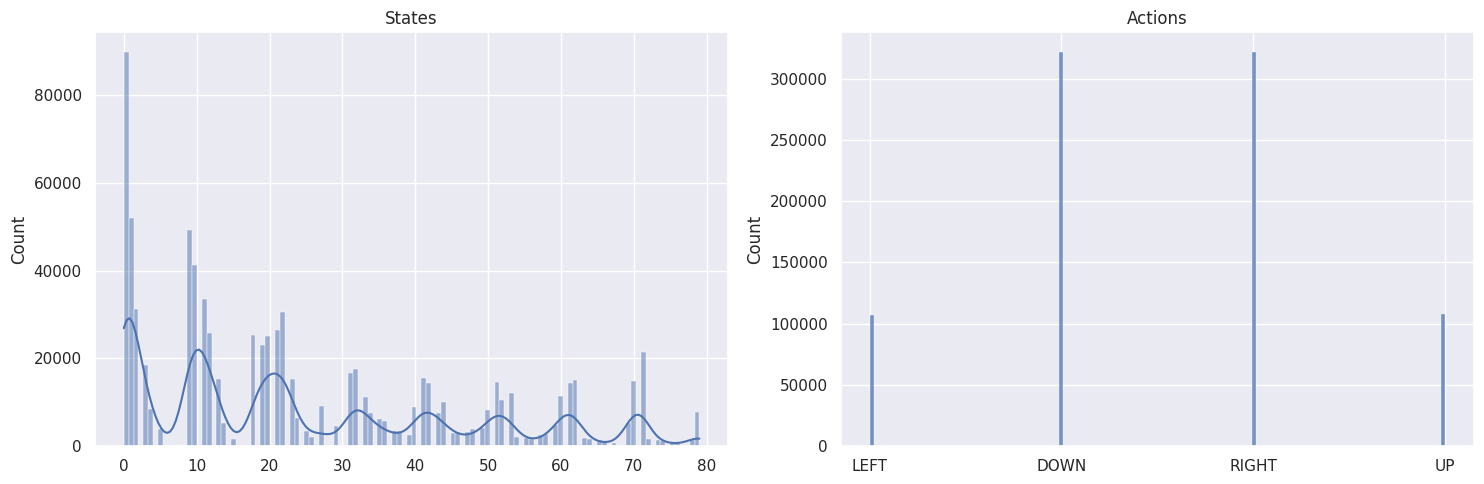

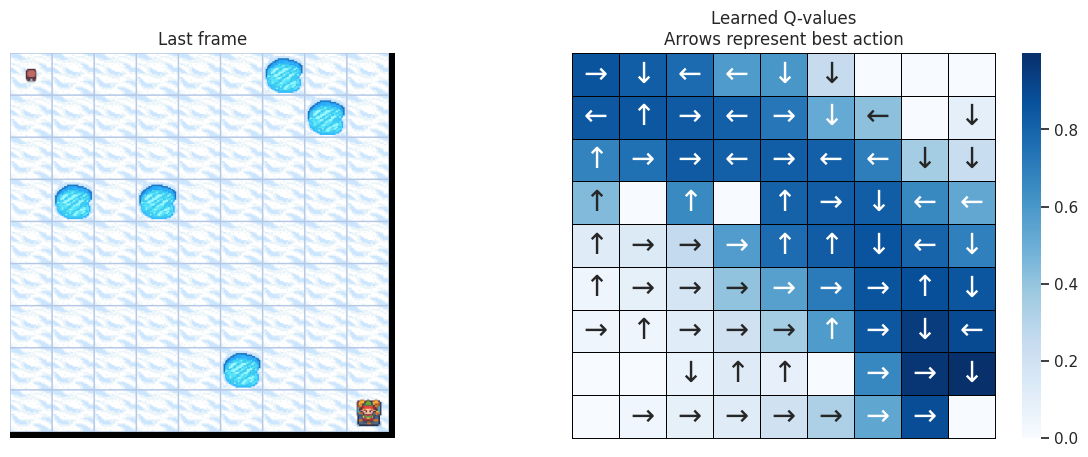

Map size: 11x11


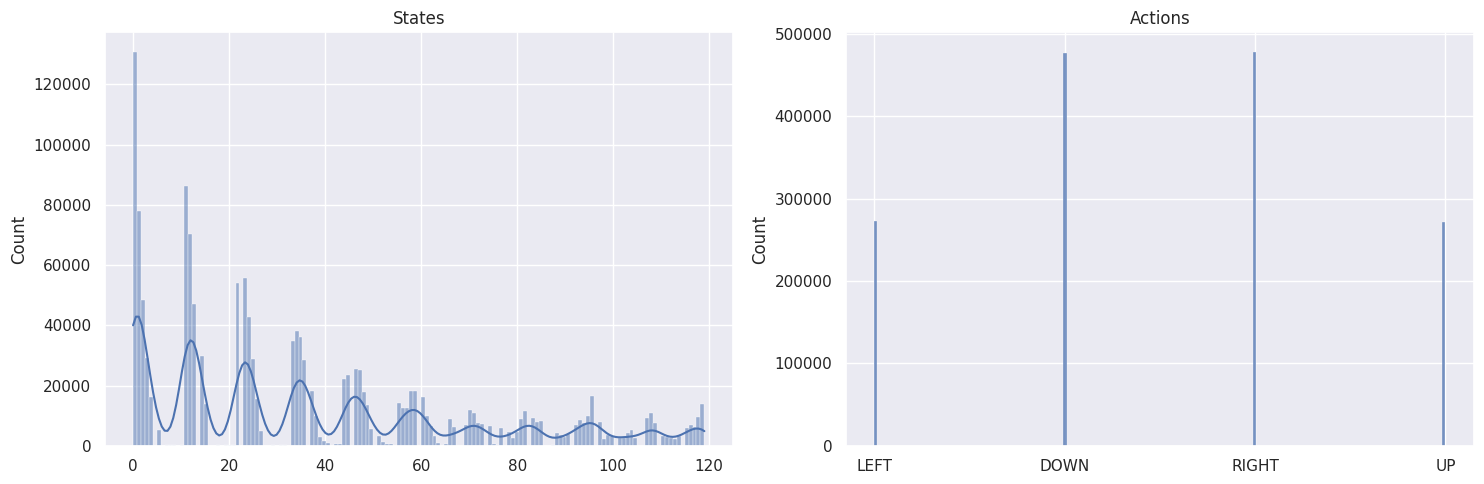

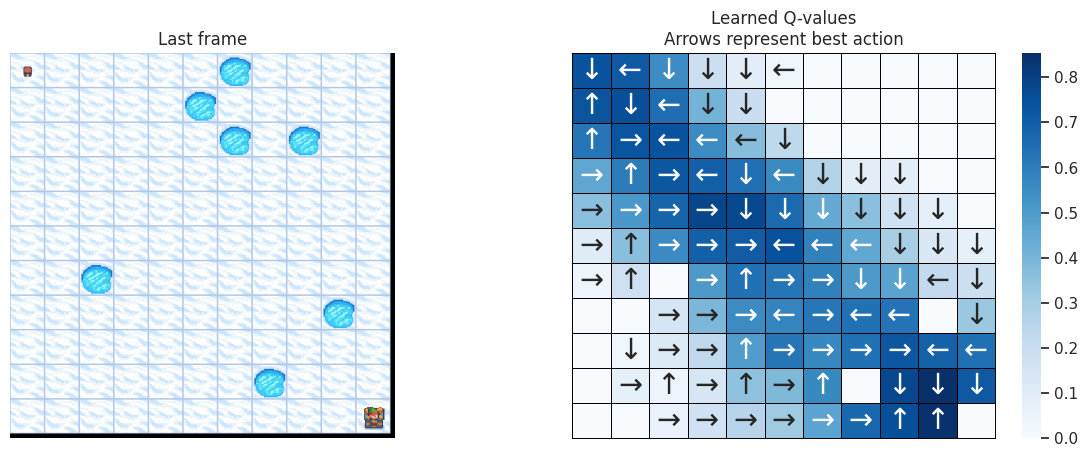

In [26]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
  env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=map_size, p=params.proba_frozen, seed=params.seed
    ),
  )

  params = params._replace(action_size=env.action_space.n)
  params = params._replace(state_size=env.observation_space.n)

  env.action_space.seed(params.seed)
  learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    action_size=params.action_size,
    state_size=params.state_size,
  )

  explorer = EpsilonGreedy(epsilon=params.epsilon)

  print(f"Map size: {map_size}x{map_size}")

  rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
  res, st = postprocess(episodes, params, rewards, steps, map_size)
  res_all = pd.concat([res_all, res])
  st_all = pd.concat([st_all, st])
  qtable = qtables.mean(axis=0)  # Average the Q-table between runs

  plot_states_actions_distribution(
      states=all_states, actions=all_actions, map_size=map_size
  )  # Sanity check
  plot_q_values_map(qtable, env, map_size)

  env.close()

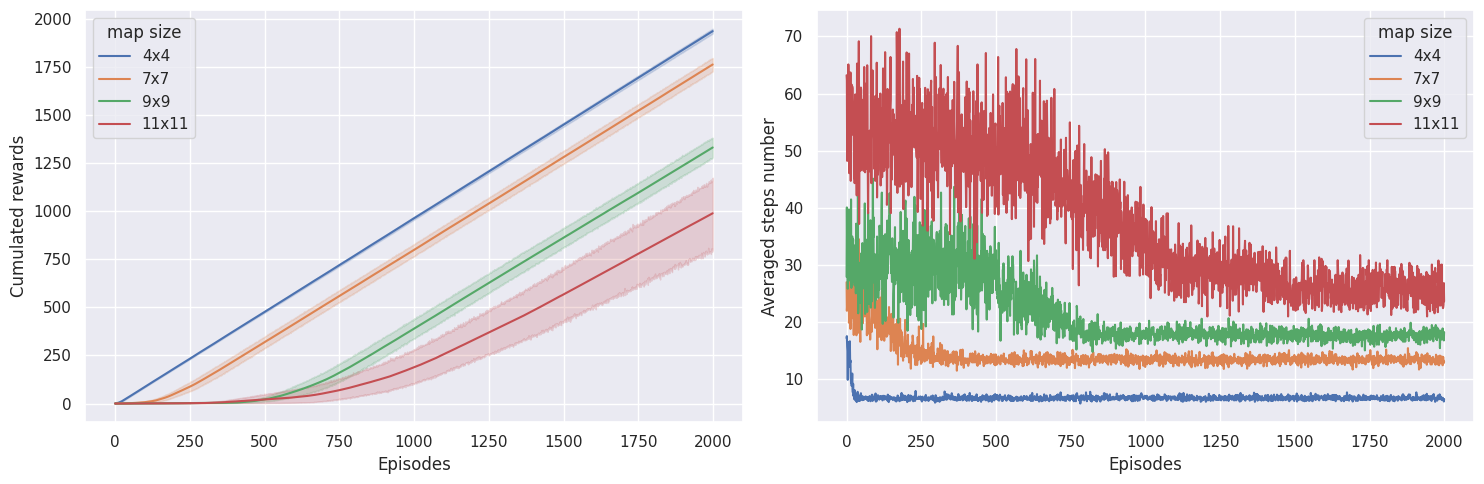

In [27]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)